In [287]:
import os
import glob
import yaml
import re

import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl

import matplotlib as mpl

import plotting as putil
import dlc as dlc
import utils as util

import importlib

In [288]:
%matplotlib notebook

In [512]:
plot_style='white'
putil.set_sns_style(style=plot_style)
bg_color='w' if plot_style=='dark' else 'k'

In [290]:
#rootdir = '/mnt/minerva/courtship-free-behavior/maDLCv2' #maDLCv2'

rootdir = '/Users/julianarhee/DeepLabCut'
projectname = 'projector-1dot-jyr-2024-02-18'
project_dir = os.path.join(rootdir, projectname) 
# load config file
cfg_fpath = os.path.join(project_dir, 'config.yaml')
with open(cfg_fpath, "r") as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)

In [291]:
minerva_base = '/Volumes/Julie/2d-projector-analysis'
analyzed_dir = os.path.join(minerva_base, 'DeepLabCut', projectname) #'analyzed')

analyzed_files = glob.glob(os.path.join(analyzed_dir, '*_el.h5'))
print("Found {} analyzed files".format(len(analyzed_files)))
#analyzed_files

Found 62 analyzed files


In [292]:
figdir = os.path.join(minerva_base, 'figures')
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [293]:
fpath = analyzed_files[2]
trk = pd.read_hdf(fpath) #os.path.join(pathname, filename))
scorer = trk.columns.get_level_values(0)[0]
fps = 60  # Hz
max_jump = 6
tstamp = np.linspace(0, len(trk) * 1 / fps, len(trk))
nframes = len(trk)

In [294]:
importlib.reload(dlc)

<module 'dlc' from '/Users/julianarhee/Repositories/flytracker-analysis/dlc.py'>

In [295]:
flyid = 'fly' # double check in the plots for abdomen lengths
dotid = 'single'

# flypos = trk.xs(flyid, level='individuals', axis=1)
# dotpos = trk.xs(dotid, level='individuals', axis=1)
fpath = analyzed_files[0]
print(os.path.split(fpath)[-1])
fps = 60  # Hz
max_jump=4
plot_checks= True

data_id = os.path.split(fpath)[-1]
sess_id = data_id.split('DLC')[0]
flydf = dlc.load_trk_df(fpath, flyid='fly', fps=fps, max_jump=max_jump, cop_ix=None)
dotdf = dlc.load_trk_df(fpath, flyid='single', fps=fps, max_jump=max_jump, cop_ix=None)
flydf, dotdf = dlc.get_interfly_params(flydf, dotdf, cop_ix=None)


20240212-1352_fly4_Dyak_sP1-ChR_3do_sh_4x4_2024-02-12-135318-0000DLC_dlcrnetms5_projector-1dotFeb18shuffle1_50000_el.h5


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


<IPython.core.display.Javascript object>


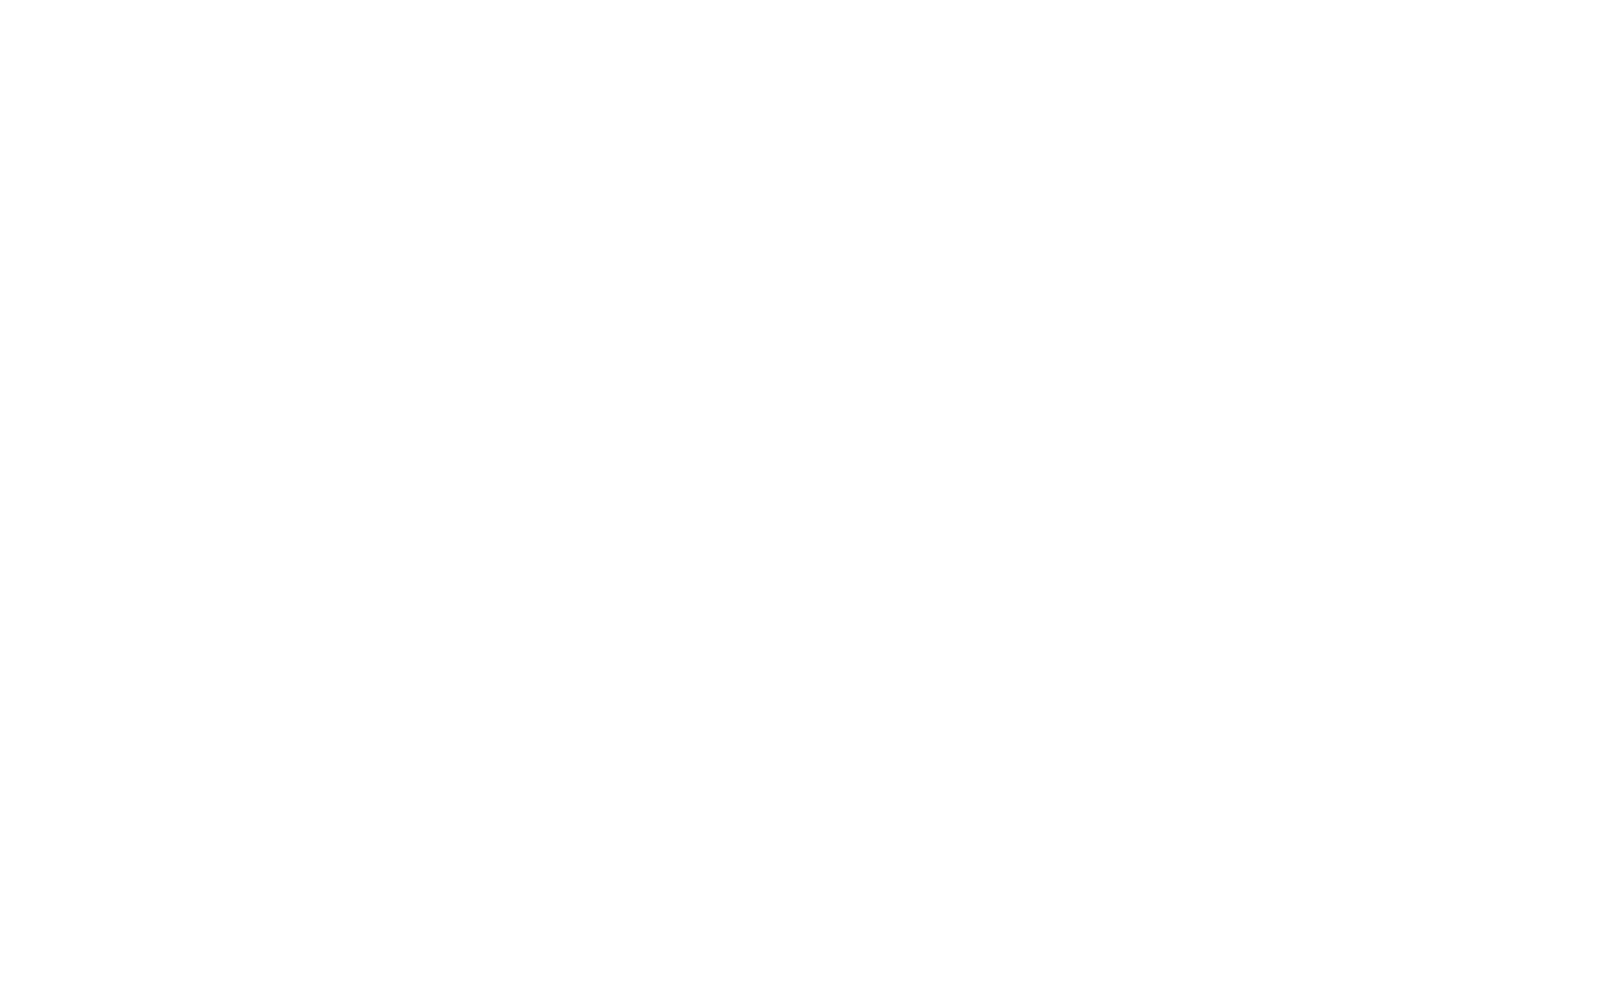

In [296]:
dotdf = dlc.smooth_speed_steps(dotdf)
if plot_checks:
    fig, ax = pl.subplots(figsize=(8, 5))
    sns.scatterplot(x='time', y='centroid_x', data=dotdf, ax=ax,
                    hue='lin_speed_filt', palette='viridis', edgecolor='none', s=5)
    putil.label_figure(fig, data_id)
    pl.savefig(os.path.join(figdir, '{}_color-vel.png'.format(sess_id)))
    pl.close()

In [298]:
dotdf = dlc.add_speed_epoch(dotdf, step_dict)
flydf = dlc.add_speed_epoch(flydf, step_dict)

dotdf = dotdf[dotdf['epoch'] < 10]
flydf = flydf[flydf['epoch'] < 10]

# FFT

In [299]:

target_freqs = {0: 0,
                1: 0.03,
                2: 0.05,
                3: 0.1,
                4: 0.2,
                5: 0.4,
                6: 0.5,
                7: 0.63,
                8: 0.8,
                9: 1.0}

In [300]:
importlib.reload(util)

<module 'utils' from '/Users/julianarhee/Repositories/flytracker-analysis/utils.py'>

In [301]:
plot_each=True

In [302]:
def do_fft_by_epoch(flydf, dotdf, plot=False):
    if plot:
        fig, axn= pl.subplots(10, 1, figsize=(6, 12))
    d_list = []
    for ai, (v, df_) in enumerate(dotdf.groupby('epoch')):
        #print(ai)
        # dot FFT
        dot_amp, dot_freq = util.get_fft(df_, fft_var='centroid_x', time_var='time')
        # fly
        flydf_ = flydf[flydf['epoch']==v].copy()
        fly_amp, fly_freq = util.get_fft(flydf_, fft_var='centroid_x',  time_var='time')
        # get amp at target freq
        target_freq_ix = np.argmin(abs(fly_freq-target_freqs[v]))
        amp_at_targ_dot = dot_amp[target_freq_ix]
        amp_at_targ_fly = fly_amp[target_freq_ix]
        # get freq at max amp
        max_amp_ix_fly = np.argmax(fly_amp)
        freq_at_max_fly = fly_freq[max_amp_ix_fly]
        max_amp_ix_dot = np.argmax(dot_amp)
        freq_at_max_dot = dot_freq[max_amp_ix_dot]

        d1 =pd.DataFrame({'epoch': v,
                     'target_freq': target_freqs[v],
                     'freq_at_max': freq_at_max_dot,
                     'amp_at_targ': amp_at_targ_dot,
                     'id': 'dot'}, index=[ai])
        d2 =pd.DataFrame({'epoch': v,
                     'target_freq': target_freqs[v],
                     'freq_at_max': freq_at_max_fly,
                     'amp_at_targ': amp_at_targ_fly,
                     'id': 'fly'}, index=[ai])
        d_ = pd.concat([d1, d2], axis=0)
        d_list.append(d_)

        # plot
        if plot:
            # plot
            ax=axn.flat[ai]
            ax.stem(dot_freq, dot_amp, 'w', markerfmt=" ", basefmt="-w")
            ax.stem(fly_freq, fly_amp, 'r', markerfmt=" ", basefmt="-r")
            ax.set_xlim([0, 1.5])
            # get max of DOT
            max_ix = np.argmax(amp)
            ax.set_title('{}: {}Hz'.format(v, freq[max_ix].round(2)), loc='left')
        #pl.subplots_adjust(hspace=0.7)
    if plot_each:
        pl.tight_layout()

    fft_ = pd.concat(d_list)
    if plot:
        return fft_, fig
    else:
        return fft_

In [481]:
importlib.reload(dlc)

<module 'dlc' from '/Users/julianarhee/Repositories/flytracker-analysis/dlc.py'>

In [483]:
plot_checks=False
plot_fft=False
errors=[]
d_list = []
for fpath in analyzed_files:
    data_id = os.path.split(fpath)[-1]
    sess_id = data_id.split('DLC')[0]
    print(sess_id)
    try:
        flydf = dlc.load_trk_df(fpath, flyid='fly', fps=fps, max_jump=max_jump, cop_ix=None)
        dotdf = dlc.load_trk_df(fpath, flyid='single', fps=fps, max_jump=max_jump, cop_ix=None)
        flydf, dotdf = dlc.get_interfly_params(flydf, dotdf, cop_ix=None)
        # smooth for epochs
        dotdf = dlc.smooth_speed_steps(dotdf)
        if plot_checks:
            fig, ax = pl.subplots(figsize=(8, 5))
            sns.scatterplot(x='time', y='centroid_x', data=dotdf, ax=ax,
                            hue='lin_speed_filt', palette='viridis', edgecolor='none', s=5)
            putil.label_figure(fig, data_id)
            pl.savefig(os.path.join(figdir, '{}_color-vel.png'.format(sess_id)))
            pl.close()
        # get epochs
        if sess_id =='20240214-1045_f1_Dele-wt_5do_sh_prj10_sz12x12_2024-02-14-104540-0000':
            n_levels = 8
        elif sess_id == '20240215-1722_fly1_Dmel_sP1-ChR_3do_sh_6x6_2024-02-15-172443-0000':
            n_levels = 9
        else:
            n_levels = 10
        step_dict = dlc.get_step_indices(dotdf, speed_var='lin_speed_filt', 
                                 t_start=20, increment=40, n_levels=n_levels)
        if plot_checks:
            fig = dlc.check_speed_steps(dotdf, step_dict)
            putil.label_figure(fig, data_id)
            pl.savefig(os.path.join(figdir, '{}_step-ixs.png'.format(sess_id)))
            pl.close()
        # ADD EPOCHS
        dotdf = dlc.add_speed_epoch(dotdf, step_dict)
        flydf = dlc.add_speed_epoch(flydf, step_dict)
        dotdf = dotdf[dotdf['epoch'] < 10]
        flydf = flydf[flydf['epoch'] < 10]
        # fft
        if plot_fft:
            fft_, fig = do_fft_by_epoch(flydf, dotdf, plot=True)
            putil.label_figure(fig, data_id)
            pl.savefig(os.path.join(figdir, '{}_fft.png'.format(sess_id)))
            pl.close()
        else:
            fft_ = do_fft_by_epoch(flydf, dotdf, plot=False)

        fft_['acquisition'] = '_'.join(sess_id.split('_')[0:-1]) #sess_id
        sz = int(re.findall('(\d+x\d+)', sess_id)[0].split('x')[0])
        fft_['size'] = sz #int(sz[0][0])
        fft_['species'] = sess_id.split('_')[2]

        d_list.append(fft_)
    except Exception as e:
        print(e)
        errors.append(fpath)
fft_df = pd.concat(d_list).reset_index()

20240212-1352_fly4_Dyak_sP1-ChR_3do_sh_4x4_2024-02-12-135318-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1230_fly3_Dmel_sP1-ChR_3do_sh_4x4_2024-02-12-122911-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240215-1749_fly1_Dmel_sP1-ChR_3do_sh_2x2_2024-02-15-175003-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1405_fly4_Dyak_sP1-ChR_3do_sh_8x8_2024-02-12-140840-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240214-0945_f1_Dele-wt_5do_sh_prj10_sz6x6_2024-02-14-094517-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1312_fly1_Dyak_sP1-ChR_2do_sh_4x4_2024-02-16-131229-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1305_fly1_Dyak_sP1-ChR_2do_sh_6x6_2024-02-16-130434-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1552_fly7_Dmel_sP1-ChR_2do_sh_4x4_2024-02-16-155224-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1537_fly6_Dyak_sP1-ChR_3do_sh_6x6_2024-02-12-154003-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240222-1611_fly7_Dmel_sP1-ChR_2do_sh_8x8_2024-02-22-161201-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1523_fly6_Dyak_sP1-ChR_3do_sh_2x2_2024-02-12-152024-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240222-1627_fly7_Dmel_sP1-ChR_2do_sh_2x2_2024-02-22-162608-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1443_fly3_Dmel_sP1-ChR_2do_sh_8x8_2024-02-16-144315-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1453_fly3_Dmel_sP1-ChR_2do_sh_2x2_2024-02-16-145510-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1130_fly2_Dyak_sP1-ChR_3do_sh_6x6_2024-02-12-113024-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240214-1002_f1_Dele-wt_5do_sh_prj10_sz8x8_2024-02-14-100259-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240211-1509_f4_Dyak-splitP1a-CsChR_2do_gh_prj10_sz4x4_2024-02-11-150946-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1607_fly7_Dmel_sP1-ChR_2do_sh_2x2_2024-02-16-160811-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240214-0954_f1_Dele-wt_5do_sh_prj10_sz2x2_2024-02-14-095429-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1237_fly3_Dmel_sP1-ChR_3do_sh_2x2_2024-02-12-123749-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1358_fly4_Dyak_sP1-ChR_3do_sh_6x6_2024-02-12-140115-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240214-1018_f1_Dele-wt_5do_sh_prj10_sz2x2_2_2024-02-14-101845-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240215-1817_fly2_Dyak_sP1-ChR_3do_sh_4x4_2024-02-15-181711-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240222-1620_fly7_Dmel_sP1-ChR_2do_sh_4x4_2024-02-22-161902-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1434_fly3_Dmel_sP1-ChR_2do_sh_4x4_2024-02-16-143537-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1318_fly1_Dyak_sP1-ChR_2do_sh_2x2_2024-02-16-131947-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240211-1451_f3_Dyak-splitP1a-CsChR_2do_gh_prj10_sz2x2_2024-02-11-145209-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1136_fly2_Dyak_sP1-ChR_3do_sh_4x4_2024-02-12-114021-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1345_fly4_Dyak_sP1-ChR_3do_sh_2x2_2024-02-12-134342-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240215-1801_fly2_Dyak_sP1-ChR_3do_sh_2x2_2024-02-15-180213-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1148_fly2_Dyak_sP1-ChR_3do_sh_8x8_2024-02-12-120131-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1422_fly3_Dmel_sP1-ChR_2do_sh_6x6_2024-02-16-142505-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1541_fly7_Dmel_sP1-ChR_2do_sh_6x6_2024-02-16-154335-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240215-1810_fly2_Dyak_sP1-ChR_3do_sh_8x8_2024-02-15-181001-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240222-1604_fly7_Dmel_sP1-ChR_2do_sh_6x6_2024-02-22-160455-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240224-1055_fly2_Dmel_sP1-ChR_2do_sh_2x2_2024-02-24-105559-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1215_fly3_Dmel_sP1-ChR_3do_sh_8x8_2024-02-12-121327-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240214-1025_f1_Dele-wt_5do_sh_prj10_sz10x10_2024-02-14-102617-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1222_fly3_Dmel_sP1-ChR_3do_sh_6x6_2024-02-12-122044-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240215-1722_fly1_Dmel_sP1-ChR_3do_sh_6x6_2024-02-15-172443-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240214-1033_f1_Dele-wt_5do_sh_prj10_sz6x6_2_2024-02-14-103359-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240222-1055_fly1_Dyak_sP1-ChR_2do_sh_8x8_2024-02-22-105904-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1515_fly6_Dyak_sP1-ChR_3do_sh_8x8_2024-02-12-151225-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240211-1430_f3_Dyak-splitP1a-CsChR_2do_gh_prj10_sz6x6_2024-02-11-142641-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240222-1126_fly1_Dyak_sP1-ChR_2do_sh_6x6_2024-02-22-112509-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240214-1055_f1_Dele-wt_5do_sh_prj10_sz6x6_10p5_2024-02-14-105544-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240214-1010_f1_Dele-wt_5do_sh_prj10_sz4x4_2024-02-14-101038-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1559_fly7_Dmel_sP1-ChR_2do_sh_8x8_2024-02-16-155945-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240222-1105_fly1_Dyak_sP1-ChR_2do_sh_2x2_2024-02-22-110956-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240214-1045_f1_Dele-wt_5do_sh_prj10_sz12x12_2024-02-14-104540-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240222-1155_fly3_Dyak_sP1-ChR_2do_sh_8x8_2024-02-22-115559-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240224-1045_fly2_Dmel_sP1-ChR_2do_sh_4x4_2024-02-24-104833-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240215-1741_fly1_Dmel_sP1-ChR_3do_sh_4x4_2024-02-15-174206-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240224-1103_fly2_Dmel_sP1-ChR_2do_sh_8x8_2024-02-24-110358-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240215-1733_fly1_Dmel_sP1-ChR_3do_sh_8x8_2024-02-15-173414-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1530_fly6_Dyak_sP1-ChR_3do_sh_4x4_2024-02-12-153025-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240215-1827_fly2_Dyak_sP1-ChR_3do_sh_6x6_2024-02-15-182702-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240216-1254_fly1_Dyak_sP1-ChR_2do_sh_8x8_2024-02-16-125559-0000


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240212-1142_fly2_Dyak_sP1-ChR_3do_sh_2x2_2024-02-12-115024-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240222-1145_fly3_Dyak_sP1-ChR_2do_sh_6x6_2024-02-22-114809-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240222-1117_fly1_Dyak_sP1-ChR_2do_sh_4x4_2024-02-22-111727-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


20240224-1032_fly2_Dmel_sP1-ChR_2do_sh_6x6_2024-02-24-104015-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:161: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/2883039349.py:47: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


In [484]:
fft_df.shape

(1238, 9)

In [485]:
fft_df[['species', 'acquisition']].drop_duplicates().groupby('species')['acquisition'].count()

species
Dele-wt                 9
Dmel                   24
Dyak                   26
Dyak-splitP1a-CsChR     3
Name: acquisition, dtype: int64

In [486]:
fft_df['target_freq'].unique()

array([0.  , 0.03, 0.05, 0.1 , 0.2 , 0.4 , 0.5 , 0.63, 0.8 , 1.  ])

In [487]:
dotdf['epoch'].unique()

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [630]:
FLY.shape

(1457949, 17)

# plot

In [513]:
plot_style='white'
putil.set_sns_style(style=plot_style)
bg_color='w' if plot_style=='dark' else 'k'

In [489]:
fft_df['size'].unique()

array([ 4,  2,  8,  6, 10, 12])

In [490]:
print(fft_df['species'].unique())
fft_df.loc[fft_df['species']=='Dyak-splitP1a-CsChR', 'species'] = 'Dyak'

['Dyak' 'Dmel' 'Dele-wt' 'Dyak-splitP1a-CsChR']


In [491]:
fft_df.groupby('species')['target_freq'].unique()

species
Dele-wt    [0.0, 0.03, 0.05, 0.1, 0.2, 0.4, 0.5, 0.63, 0....
Dmel       [0.0, 0.03, 0.05, 0.1, 0.2, 0.4, 0.5, 0.63, 0....
Dyak       [0.0, 0.03, 0.05, 0.1, 0.2, 0.4, 0.5, 0.63, 0....
Name: target_freq, dtype: object

In [600]:
curr_species = ['Dmel', 'Dyak'] #, 'Dele-wt']
plotdf = fft_df[(fft_df['species'].isin(curr_species))
               & (fft_df['size'].isin(curr_sizes))].copy()

<IPython.core.display.Javascript object>


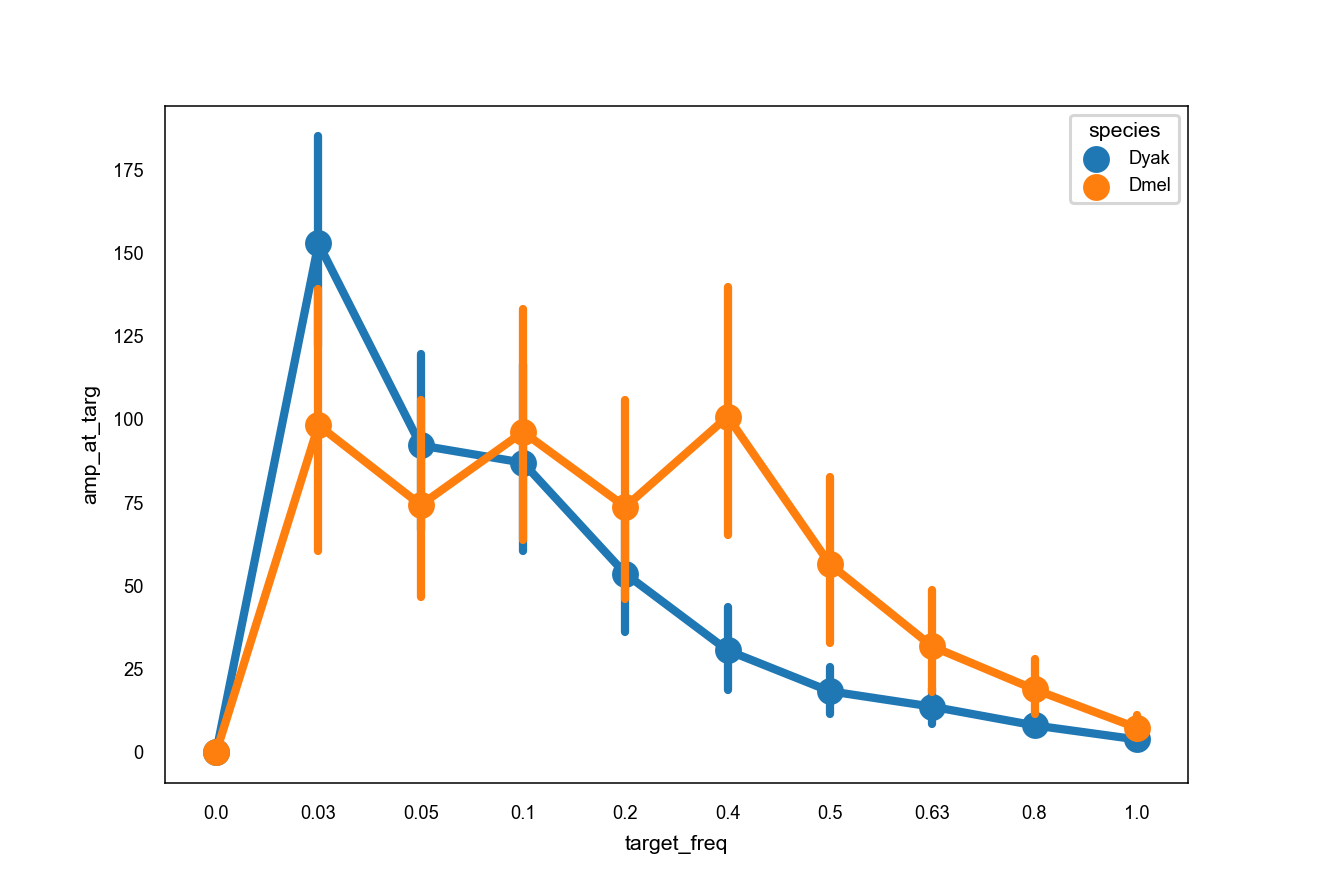

<Axes: xlabel='target_freq', ylabel='amp_at_targ'>

In [601]:
fig, ax = pl.subplots() #1, 2)
# ax=axn[0]
# sns.pointplot(data=plotdf[plotdf['id']=='dot'], ax=ax, hue='species',
#                x='target_freq', y='amp_at_targ')
# ax=axn[1]
sns.pointplot(data=plotdf[plotdf['id']=='fly'], ax=ax, hue='species',
               x='target_freq', y='amp_at_targ')

In [602]:
plotdf.groupby(['size', 'epoch', 'species']).describe()

index                                    target_freq        \
                   count mean  std  min  25%  50%  75%  max       count  mean   
size epoch species                                                              
2    0.0   Dmel     12.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        12.0  0.00   
           Dyak     14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        14.0  0.00   
     1.0   Dmel     12.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0        12.0  0.03   
           Dyak     14.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0        14.0  0.03   
     2.0   Dmel     12.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0        12.0  0.05   
...                  ...  ...  ...  ...  ...  ...  ...  ...         ...   ...   
8    7.0   Dyak     14.0  7.0  0.0  7.0  7.0  7.0  7.0  7.0        14.0  0.63   
     8.0   Dmel     12.0  8.0  0.0  8.0  8.0  8.0  8.0  8.0        12.0  0.80   
           Dyak     14.0  8.0  0.0  8.0  8.0  8.0  8.0  8.0        14.0  0.80   
     9.0   Dmel     12.0  9.0  0.0  9.0  9.0  9.0  9.0  9.0        12.0  1.00   
           Dyak     14.0  9.0  0.0  9.0  9.0  9.0  9.0  9.0        14.0  1.00   

                    ... freq_at_max            amp_at_targ                \
                    ...         75%        max       count          mean   
size epoch species  ...                                                    
2    0.0   Dmel     ...    0.579172  14.625211        10.0  4.810496e-14   
           Dyak     ...    3.367613  25.126258        13.0  5.141362e-14   
     1.0   Dmel     ...    0.031296   0.124995         8.0  1.759486e+02   
           Dyak     ...    0.025020   0.100079         8.0  2.019109e+02   
     2.0   Dmel     ...    0.050066   0.099996        11.0  2.352652e+02   
...                 ...         ...        ...         ...           ...   
8    7.0   Dyak     ...    0.625300   0.643651        11.0  1.612357e+02   
     8.0   Dmel     ...    0.799482   0.801302        10.0  1.498749e+02   
           Dyak     ...    0.799633   0.801302         9.0  1.908635e+02   
     9.0   Dmel     ...    1.004984   1.011194        10.0  1.211251e+02   
           Dyak     ...    1.004353   1.005826        13.0  1.757125e+02   

                                                                            \
                             std           min           25%           50%   
size epoch species                                                           
2    0.0   Dmel     4.727612e-14  3.144105e-15  6.632268e-15  3.774505e-14   
           Dyak     4.827901e-14  5.988771e-16  2.086496e-14  4.096660e-14   
     1.0   Dmel     1.369253e+02  5.103140e+00  1.034005e+02  1.373888e+02   
           Dyak     1.193098e+02  6.682817e+01  1.091010e+02  1.764386e+02   
     2.0   Dmel     1.377238e+02  3.738936e+00  1.411015e+02  2.921204e+02   
...                          ...           ...           ...           ...   
8    7.0   Dyak     1.592954e+02  1.358035e+00  2.429958e+01  4.696360e+01   
     8.0   Dmel     1.549512e+02  1.117630e+00  2.409322e+01  6.639311e+01   
           Dyak     1.706118e+02  4.702164e+00  1.513696e+01  3.201776e+02   
     9.0   Dmel     1.466527e+02  4.352417e-01  6.101448e+00  1.687225e+01   
           Dyak     1.674161e+02  1.954248e-01  3.105662e+00  3.066182e+02   

                                                
                             75%           max  
size epoch species                              
2    0.0   Dmel     8.188302e-14  1.321866e-13  
           Dyak     6.408318e-14  1.871771e-13  
     1.0   Dmel     3.210447e+02  3.413775e+02  
           Dyak     3.212921e+02  3.613422e+02  
     2.0   Dmel     3.301123e+02  4.048805e+02  
...                          ...           ...  
8    7.0   Dyak     3.211816e+02  3.724313e+02  
     8.0   Dmel     3.203704e+02  3.362080e+02  
           Dyak     3.206058e+02  3.719357e+02  
     9.0   Dmel     2.878686e+02  3.102702e+02  
           Dyak     3.103623e+02  3.555882e+02  

[80 rows x 32 columns]

<IPython.core.display.Javascript object>


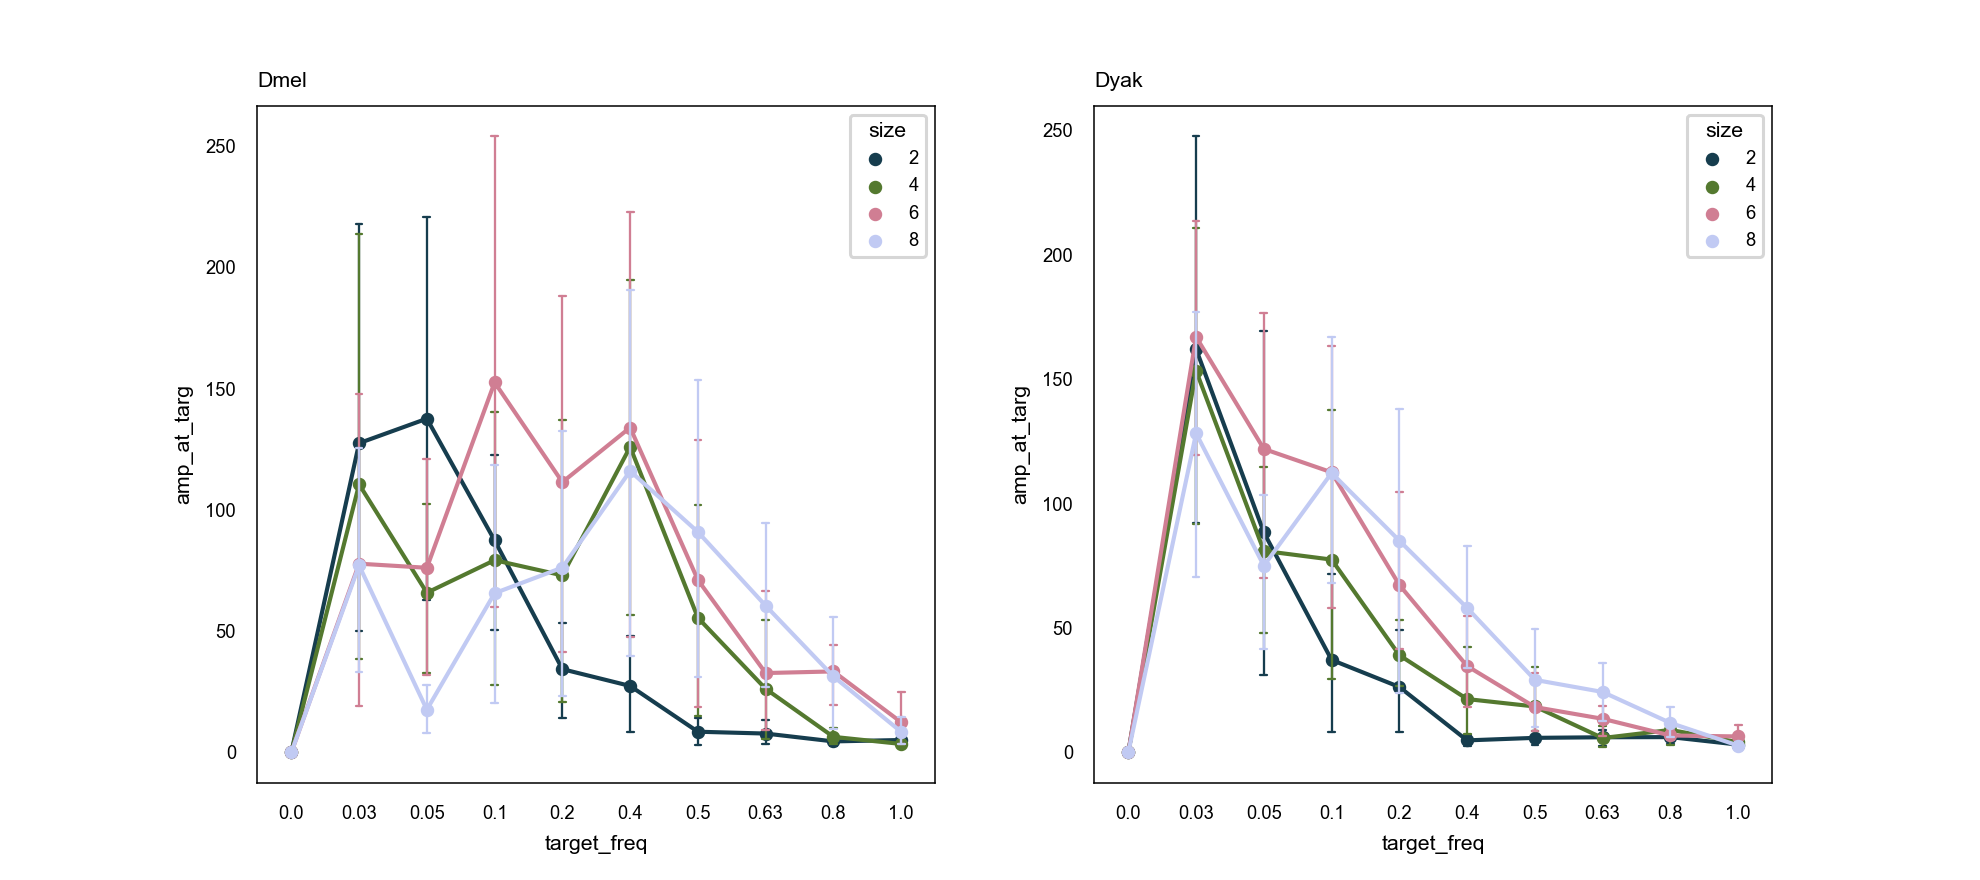

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


In [614]:
fig, axn = pl.subplots(1,2, figsize=(9,4))
for ai, (sp, df_) in enumerate(plotdf.groupby('species')):
    ax=axn[ai]
    sns.pointplot(data=df_[df_['id']=='fly'], ax=ax, hue='size',
               x='target_freq', y='amp_at_targ',palette='cubehelix',
               scale=0.5, errorbar=("ci", 95), capsize=.1, errwidth=0.75)
    ax.set_title(sp, loc='left')
    ax.set_box_aspect(1)

In [541]:
fft_df['size'].unique()

array([ 4,  2,  8,  6, 10, 12])

In [542]:
meandf = fft_df.groupby(['id', 'species', 'size', 'target_freq'])['amp_at_targ'].mean().reset_index()

In [543]:
vmin, vmax = meandf['amp_at_targ'].min(), meandf['amp_at_targ'].max()

fig, axn = pl.subplots(1, 3, figsize=(8,4))
curr_sizes = [2, 4, 6, 8]
plotdf = meandf[meandf['size'].isin(curr_sizes)].copy()

vmax=200
cbar_ax = fig.add_axes([0.91, .4, .02, .2])
for ai, (sp, df_) in enumerate(plotdf[plotdf['id']=='fly'].groupby('species')):
    tuning = df_.pivot_table(values='amp_at_targ', columns=['target_freq'], 
                index=['size'])
    ax=axn[ai]
    ax.set_title(sp, loc='left')
    sns.heatmap(data=tuning, ax=ax, vmin=vmin, vmax=vmax, cmap='magma',
                cbar=ai!=0, cbar_ax=None if ai==0 else cbar_ax)
    ax.set_aspect(1)
    #ax.imshow(tuning.values, vmin=vmin, vmax=vmax)
fig.tight_layout(rect=[0, 0, .9, 1])

In [471]:
vmin, vmax

(1.1196600460064443, 352.41494311387487)

## JAAAB bouts

In [652]:
import pickle as pkl
importlib.reload(dlc)

<module 'dlc' from '/Users/julianarhee/Repositories/flytracker-analysis/dlc.py'>

In [668]:
srcfile = '/Users/julianarhee/Documents/rutalab/projects/courtship/2d-projector/JAABA/projector.pkl'
with open(srcfile, 'rb') as f:
    jaaba = pkl.load(f)

In [669]:
jaaba['is_singing'] = 0
jaaba.loc[jaaba['singing']>15, 'is_singing'] = 1

jaaba['is_chasing'] = 0
jaaba.loc[jaaba['chasing']>15, 'is_chasing'] = 1

jaaba['is_orienting'] = 0
jaaba.loc[jaaba['orienting']>15, 'is_orienting'] = 1

In [658]:
errors=[]
d_list = []
for fpath in analyzed_files:
    data_id = os.path.split(fpath)[-1]
    sess_id = data_id.split('DLC')[0]
    print(sess_id)
    flydf = dlc.load_trk_df(fpath, flyid='fly', fps=fps, max_jump=max_jump, cop_ix=None)
    dotdf = dlc.load_trk_df(fpath, flyid='single', fps=fps, max_jump=max_jump, cop_ix=None)
    flydf, dotdf = dlc.get_interfly_params(flydf, dotdf, cop_ix=None)
    # smooth for epochs
    dotdf = dlc.smooth_speed_steps(dotdf)
    # get epochs
    if sess_id =='20240214-1045_f1_Dele-wt_5do_sh_prj10_sz12x12_2024-02-14-104540-0000':
        n_levels = 8
    elif sess_id == '20240215-1722_fly1_Dmel_sP1-ChR_3do_sh_6x6_2024-02-15-172443-0000':
        n_levels = 9
    else:
        n_levels = 10
    step_dict = dlc.get_step_indices(dotdf, speed_var='lin_speed_filt', 
                             t_start=20, increment=40, n_levels=n_levels)
    # ADD EPOCHS
    #dotdf = dlc.add_speed_epoch(dotdf, step_dict)
    flydf = dlc.add_speed_epoch(flydf, step_dict)
    flydf['target_freq'] = [target_freqs[v] if v in target_freqs.keys() else None for v in flydf['epoch']]
    flydf['dot_lin_speed'] = dotdf['lin_speed']
    flydf['dot_lin_speed_filt'] = dotdf['lin_speed_filt']
    #dotdf = dotdf[dotdf['epoch'] < 10]
    #flydf = flydf[flydf['epoch'] < 10]
    flydf['acquisition'] = '_'.join(sess_id.split('_')[0:-1]) #sess_id
    sz = int(re.findall('(\d+x\d+)', sess_id)[0].split('x')[0])
    flydf['size'] = sz #int(sz[0][0])
    flydf['species'] = sess_id.split('_')[2]
    d_list.append(flydf)
FLY = pd.concat(d_list)

20240212-1352_fly4_Dyak_sP1-ChR_3do_sh_4x4_2024-02-12-135318-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1230_fly3_Dmel_sP1-ChR_3do_sh_4x4_2024-02-12-122911-0000
20240215-1749_fly1_Dmel_sP1-ChR_3do_sh_2x2_2024-02-15-175003-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1405_fly4_Dyak_sP1-ChR_3do_sh_8x8_2024-02-12-140840-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240214-0945_f1_Dele-wt_5do_sh_prj10_sz6x6_2024-02-14-094517-0000
20240216-1312_fly1_Dyak_sP1-ChR_2do_sh_4x4_2024-02-16-131229-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240216-1305_fly1_Dyak_sP1-ChR_2do_sh_6x6_2024-02-16-130434-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240216-1552_fly7_Dmel_sP1-ChR_2do_sh_4x4_2024-02-16-155224-0000
20240212-1537_fly6_Dyak_sP1-ChR_3do_sh_6x6_2024-02-12-154003-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240222-1611_fly7_Dmel_sP1-ChR_2do_sh_8x8_2024-02-22-161201-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1523_fly6_Dyak_sP1-ChR_3do_sh_2x2_2024-02-12-152024-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240222-1627_fly7_Dmel_sP1-ChR_2do_sh_2x2_2024-02-22-162608-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240216-1443_fly3_Dmel_sP1-ChR_2do_sh_8x8_2024-02-16-144315-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240216-1453_fly3_Dmel_sP1-ChR_2do_sh_2x2_2024-02-16-145510-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1130_fly2_Dyak_sP1-ChR_3do_sh_6x6_2024-02-12-113024-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240214-1002_f1_Dele-wt_5do_sh_prj10_sz8x8_2024-02-14-100259-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240211-1509_f4_Dyak-splitP1a-CsChR_2do_gh_prj10_sz4x4_2024-02-11-150946-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240216-1607_fly7_Dmel_sP1-ChR_2do_sh_2x2_2024-02-16-160811-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240214-0954_f1_Dele-wt_5do_sh_prj10_sz2x2_2024-02-14-095429-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1237_fly3_Dmel_sP1-ChR_3do_sh_2x2_2024-02-12-123749-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1358_fly4_Dyak_sP1-ChR_3do_sh_6x6_2024-02-12-140115-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240214-1018_f1_Dele-wt_5do_sh_prj10_sz2x2_2_2024-02-14-101845-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240215-1817_fly2_Dyak_sP1-ChR_3do_sh_4x4_2024-02-15-181711-0000
20240222-1620_fly7_Dmel_sP1-ChR_2do_sh_4x4_2024-02-22-161902-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240216-1434_fly3_Dmel_sP1-ChR_2do_sh_4x4_2024-02-16-143537-0000
20240216-1318_fly1_Dyak_sP1-ChR_2do_sh_2x2_2024-02-16-131947-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240211-1451_f3_Dyak-splitP1a-CsChR_2do_gh_prj10_sz2x2_2024-02-11-145209-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1136_fly2_Dyak_sP1-ChR_3do_sh_4x4_2024-02-12-114021-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1345_fly4_Dyak_sP1-ChR_3do_sh_2x2_2024-02-12-134342-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240215-1801_fly2_Dyak_sP1-ChR_3do_sh_2x2_2024-02-15-180213-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1148_fly2_Dyak_sP1-ChR_3do_sh_8x8_2024-02-12-120131-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240216-1422_fly3_Dmel_sP1-ChR_2do_sh_6x6_2024-02-16-142505-0000
20240216-1541_fly7_Dmel_sP1-ChR_2do_sh_6x6_2024-02-16-154335-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240215-1810_fly2_Dyak_sP1-ChR_3do_sh_8x8_2024-02-15-181001-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240222-1604_fly7_Dmel_sP1-ChR_2do_sh_6x6_2024-02-22-160455-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240224-1055_fly2_Dmel_sP1-ChR_2do_sh_2x2_2024-02-24-105559-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1215_fly3_Dmel_sP1-ChR_3do_sh_8x8_2024-02-12-121327-0000
20240214-1025_f1_Dele-wt_5do_sh_prj10_sz10x10_2024-02-14-102617-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1222_fly3_Dmel_sP1-ChR_3do_sh_6x6_2024-02-12-122044-0000
20240215-1722_fly1_Dmel_sP1-ChR_3do_sh_6x6_2024-02-15-172443-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240214-1033_f1_Dele-wt_5do_sh_prj10_sz6x6_2_2024-02-14-103359-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240222-1055_fly1_Dyak_sP1-ChR_2do_sh_8x8_2024-02-22-105904-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240212-1515_fly6_Dyak_sP1-ChR_3do_sh_8x8_2024-02-12-151225-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240211-1430_f3_Dyak-splitP1a-CsChR_2do_gh_prj10_sz6x6_2024-02-11-142641-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240222-1126_fly1_Dyak_sP1-ChR_2do_sh_6x6_2024-02-22-112509-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240214-1055_f1_Dele-wt_5do_sh_prj10_sz6x6_10p5_2024-02-14-105544-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240214-1010_f1_Dele-wt_5do_sh_prj10_sz4x4_2024-02-14-101038-0000
20240216-1559_fly7_Dmel_sP1-ChR_2do_sh_8x8_2024-02-16-155945-0000
20240222-1105_fly1_Dyak_sP1-ChR_2do_sh_2x2_2024-02-22-110956-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240214-1045_f1_Dele-wt_5do_sh_prj10_sz12x12_2024-02-14-104540-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240222-1155_fly3_Dyak_sP1-ChR_2do_sh_8x8_2024-02-22-115559-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240224-1045_fly2_Dmel_sP1-ChR_2do_sh_4x4_2024-02-24-104833-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240215-1741_fly1_Dmel_sP1-ChR_3do_sh_4x4_2024-02-15-174206-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240224-1103_fly2_Dmel_sP1-ChR_2do_sh_8x8_2024-02-24-110358-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240215-1733_fly1_Dmel_sP1-ChR_3do_sh_8x8_2024-02-15-173414-0000
20240212-1530_fly6_Dyak_sP1-ChR_3do_sh_4x4_2024-02-12-153025-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240215-1827_fly2_Dyak_sP1-ChR_3do_sh_6x6_2024-02-15-182702-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240216-1254_fly1_Dyak_sP1-ChR_2do_sh_8x8_2024-02-16-125559-0000
20240212-1142_fly2_Dyak_sP1-ChR_3do_sh_2x2_2024-02-12-115024-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240222-1145_fly3_Dyak_sP1-ChR_2do_sh_6x6_2024-02-22-114809-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240222-1117_fly1_Dyak_sP1-ChR_2do_sh_4x4_2024-02-22-111727-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240224-1032_fly2_Dmel_sP1-ChR_2do_sh_6x6_2024-02-24-104015-0000


/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


In [693]:
jaaba['courting'].max()

1

In [694]:
# for acq, df_ in fft_df.groupby('acquisition'):
#     df_
missing_jaaba=[]
incorrect_size = []
d_list = []
for acq, df_ in FLY.groupby('acquisition'):
    sub_jaaba = jaaba[jaaba['acquisition']==acq][['courting', 'is_singing', 'is_chasing', 'is_orienting']].copy()
    if len(sub_jaaba)==0:
        missing_jaaba.append(acq)
        continue
    if df_.shape[0] != sub_jaaba.shape[0]:
        print("flydf: {} vs. jaaba: {}".format(str(df_.shape), str(sub_jaaba.shape)))
        incorrect_size.append(acq)
        continue
    combined_ = pd.concat([df_, sub_jaaba], axis=1)
    d_list.append(combined_)
jfly = pd.concat(d_list)

flydf: (21964, 18) vs. jaaba: (24000, 4)


#### calculate bouts

In [698]:
def split_into_bouts(bin_, bout_marker='courting'):
    diff_ = bin_[bout_marker].diff()
    bout_starts = np.where(diff_!=0)[0] # each of these index values is the START ix of a bout
    for i, v in enumerate(bout_starts):
        if i == len(bout_starts)-1:
            bin_.loc[v:, 'boutnum'] = i
        else:
            v2 = bout_starts[i+1]
            bin_.loc[v:v2, 'boutnum'] = i
    return bin_

In [699]:
d_list = []
for acq, df_ in jfly.groupby('acquisition'):
    df_ = split_into_bouts(df_)
    d_list.append(df_)
jfly = pd.concat(d_list)

In [689]:
missing_jaaba

['20240211-1430_f3_Dyak-splitP1a-CsChR_2do_gh_prj10_sz6x6',
 '20240211-1451_f3_Dyak-splitP1a-CsChR_2do_gh_prj10_sz2x2',
 '20240211-1509_f4_Dyak-splitP1a-CsChR_2do_gh_prj10_sz4x4',
 '20240212-1142_fly2_Dyak_sP1-ChR_3do_sh_2x2',
 '20240212-1237_fly3_Dmel_sP1-ChR_3do_sh_2x2',
 '20240212-1345_fly4_Dyak_sP1-ChR_3do_sh_2x2',
 '20240212-1523_fly6_Dyak_sP1-ChR_3do_sh_2x2',
 '20240214-0945_f1_Dele-wt_5do_sh_prj10_sz6x6',
 '20240214-0954_f1_Dele-wt_5do_sh_prj10_sz2x2',
 '20240214-1002_f1_Dele-wt_5do_sh_prj10_sz8x8',
 '20240214-1010_f1_Dele-wt_5do_sh_prj10_sz4x4',
 '20240214-1018_f1_Dele-wt_5do_sh_prj10_sz2x2_2',
 '20240214-1025_f1_Dele-wt_5do_sh_prj10_sz10x10',
 '20240214-1033_f1_Dele-wt_5do_sh_prj10_sz6x6_2',
 '20240214-1045_f1_Dele-wt_5do_sh_prj10_sz12x12',
 '20240214-1055_f1_Dele-wt_5do_sh_prj10_sz6x6_10p5',
 '20240215-1749_fly1_Dmel_sP1-ChR_3do_sh_2x2',
 '20240215-1801_fly2_Dyak_sP1-ChR_3do_sh_2x2',
 '20240216-1318_fly1_Dyak_sP1-ChR_2do_sh_2x2',
 '20240216-1453_fly3_Dmel_sP1-ChR_2do_sh_2x2',

In [706]:
jfly['orienting_only'] = 0
jfly.loc[(jfly['courting']==1) & (jfly['is_singing']==0) & (jfly['is_chasing']==0), \
         'orienting_only'] = 1

jfly['chasing_only'] = 0
jfly.loc[(jfly['courting']==1) & (jfly['is_singing']==0), \
         'chasing_only'] = 1

In [717]:
varnames = ['courting', 'is_singing', 'is_orienting', 'is_chasing',
           'orienting_only', 'chasing_only']
mean_perbout = jfly.groupby(['species', 'size', 'target_freq', 'boutnum'])[varnames].mean().reset_index()
means_xbout = mean_perbout.groupby(['species', 'size', 'target_freq'])[varnames].mean().reset_index()
means_all = jfly.groupby(['species', 'size', 'target_freq'])[varnames].mean().reset_index()

In [753]:
mean_peracq_perbout = jfly.groupby(['species', 'size', 'target_freq', 'acquisition', 'boutnum'])[varnames].mean().reset_index()


<IPython.core.display.Javascript object>


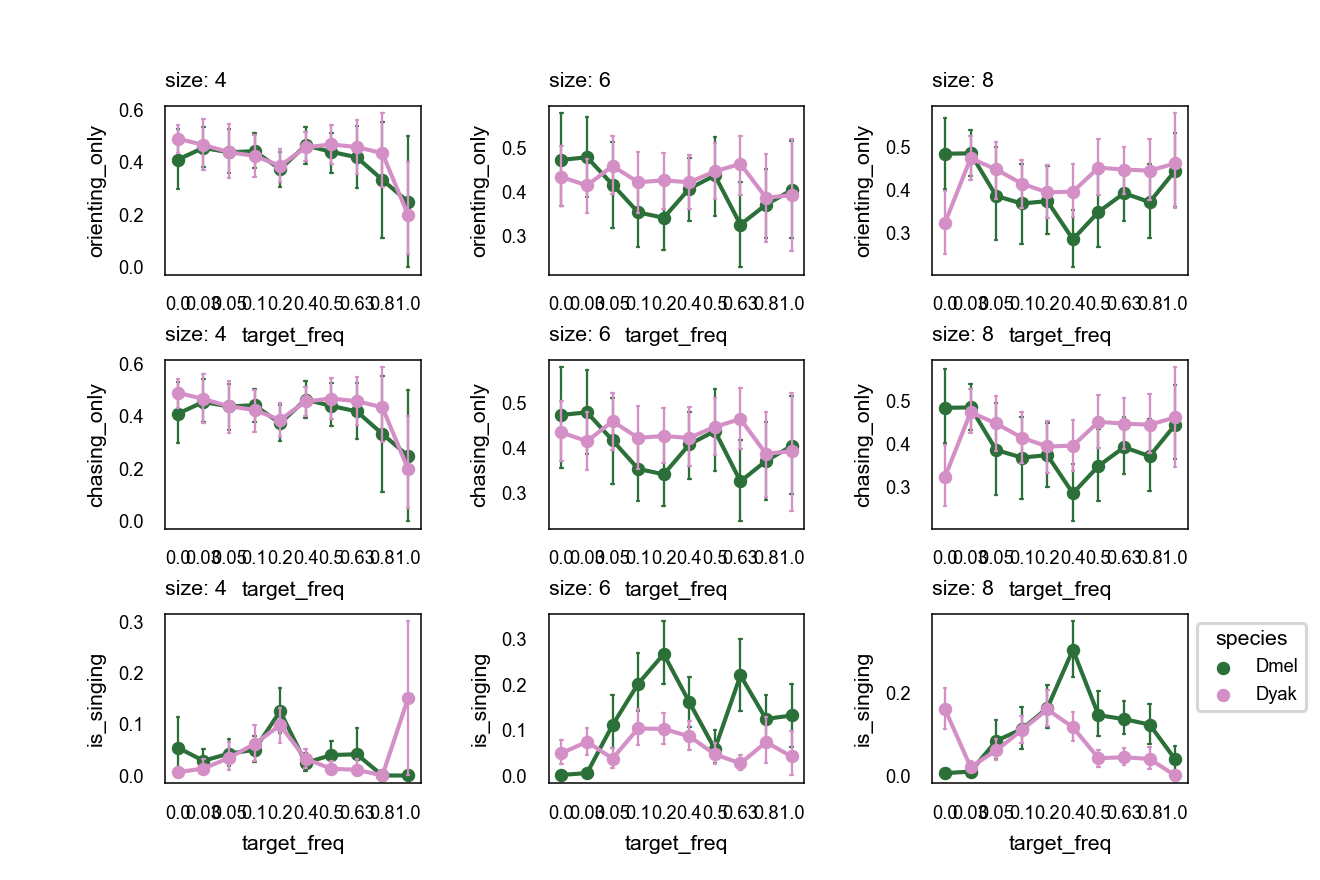

In [754]:
fig, axn =pl.subplots(3,3)
for ri, var in enumerate(['orienting_only', 'chasing_only', 'is_singing']):
    for ci, (sz, df_) in enumerate(mean_peracq_perbout.groupby('size')):
        ax=axn[ri, ci]
        sns.pointplot(data=df_, x='target_freq', y=var, hue='species', ax=ax,
                     palette='cubehelix',
               scale=0.5, errorbar=("ci", 95), capsize=.1, errwidth=0.75)
        if (ri==2 and ci==2):
            sns.move_legend(ax, bbox_to_anchor=(1,1), loc='upper left')
        else:
            ax.legend_.remove()
        
        ax.set_title("size: {}".format(sz), loc='left')
pl.subplots_adjust(wspace=0.5, hspace=0.5)

0.0005579189622707301 0.6189880803534217


<IPython.core.display.Javascript object>


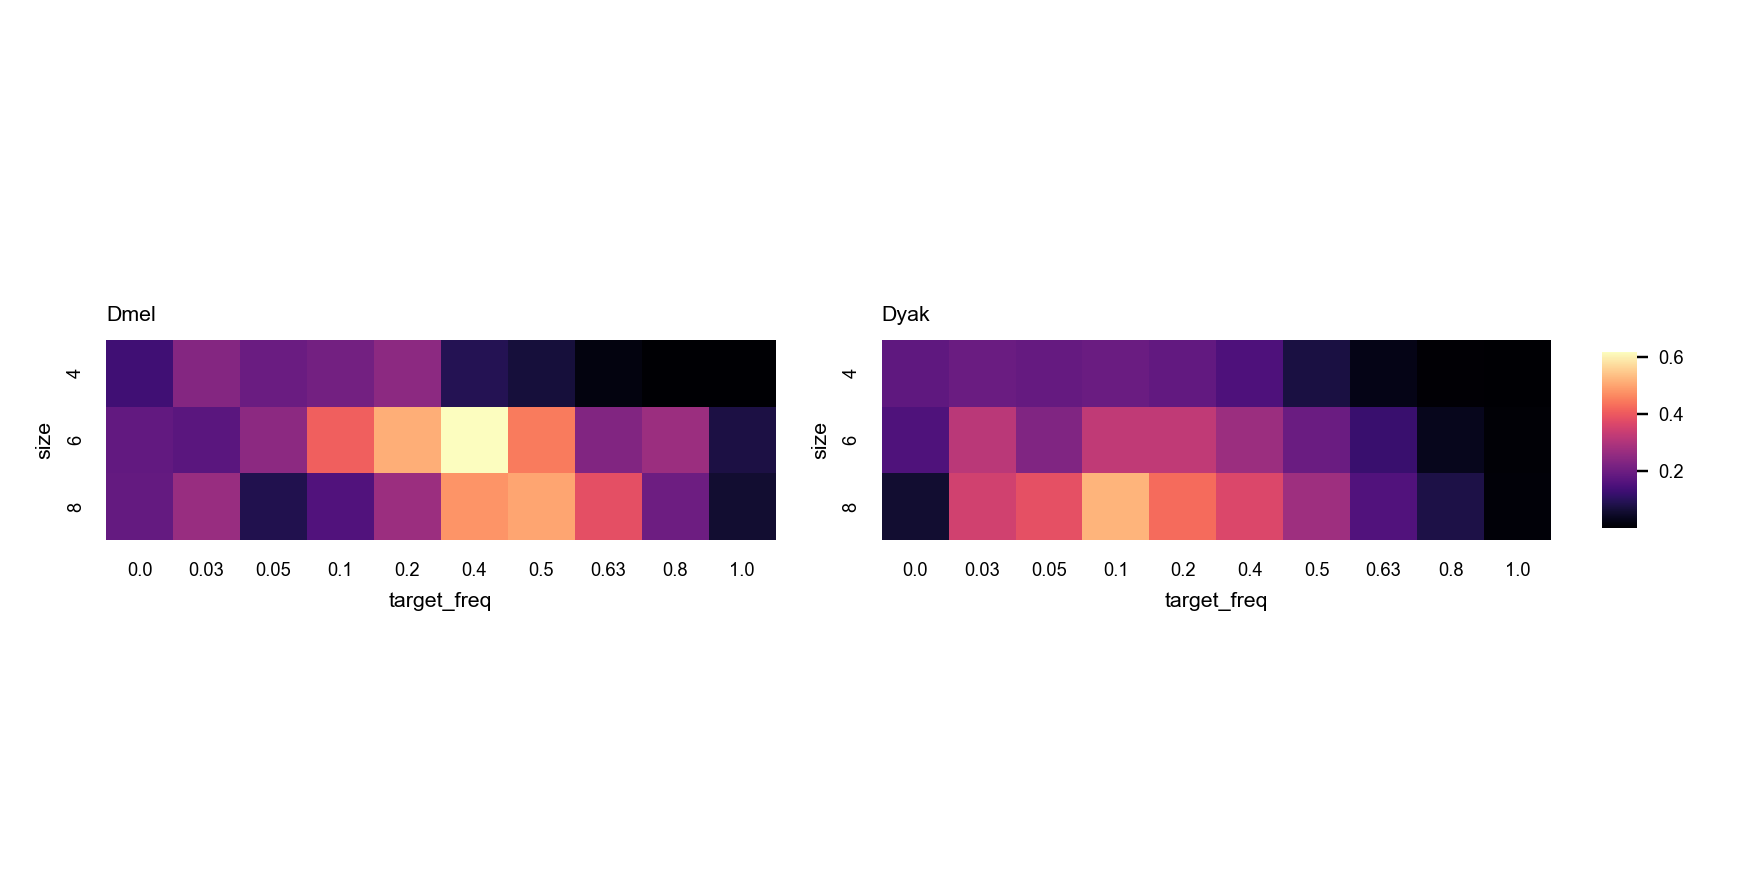

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_73803/874105251.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [723]:
print(vmin, vmax)
fig, axn = pl.subplots(1, 2, figsize=(8,4))
curr_sizes = [2, 4, 6, 8]
curr_var = 'courting'
plotdf = means_all[means_all['size'].isin(curr_sizes)].copy()
vmin, vmax = plotdf[curr_var].min(), plotdf[curr_var].max()
# vmin =0; vmax=1;
#vmax=0.5
cbar_ax = fig.add_axes([0.91, .4, .02, .2])
for ai, (sp, df_) in enumerate(plotdf.groupby('species')):
    tuning = df_.pivot_table(values=curr_var, columns=['target_freq'], 
                index=['size'])
    ax=axn[ai]
    ax.set_title(sp, loc='left')
    sns.heatmap(data=tuning, ax=ax, vmin=vmin, vmax=vmax, cmap='magma',
                cbar=ai!=0, cbar_ax=None if ai==0 else cbar_ax) #, annot=True)
    ax.set_aspect(1)
    #ax.imshow(tuning.values, vmin=vmin, vmax=vmax)
fig.tight_layout(rect=[0, 0, .9, 1])

In [714]:
plotdf

,species,size,target_freq,courting,is_singing,is_orienting,is_chasing,orienting_only,chasing_only
0,Dmel,4,0.00,0.437229,0.061789,0.420394,0.061789,0.375440,0.375440
1,Dmel,4,0.03,0.480973,0.047104,0.490788,0.047104,0.441523,0.441523
2,Dmel,4,0.05,0.464987,0.054774,0.575007,0.054774,0.416747,0.416747
3,Dmel,4,0.10,0.471982,0.039516,0.507573,0.039516,0.432814,0.432814
4,Dmel,4,0.20,0.492880,0.130075,0.461306,0.130075,0.367683,0.367683
5,Dmel,4,0.40,0.486111,0.031179,0.501442,0.031179,0.461876,0.461876
6,Dmel,4,0.50,0.472582,0.041743,0.441734,0.041743,0.430839,0.430839
7,Dmel,4,0.63,0.460526,0.041353,0.447368,0.041353,0.419173,0.419173
8,Dmel,4,0.80,0.294167,0.000000,0.294167,0.000000,0.294167,0.294167
9,Dmel,4,1.00,0.250000,0.000000,0.250000,0.000000,0.250000,0.250000


In [249]:
train_vids = glob.glob(os.path.join(project_dir, 'videos', '*.avi'))

for v in train_vids:
    vname = os.path.split(os.path.splitext(v)[0])[-1]
    #print(vname)
analyzed_vids = [os.path.split(v)[-1].split('DLC')[0] for v in analyzed_files]
print(len(analyzed_vids))
train_vid_names = [os.path.split(os.path.splitext(v)[0])[-1] for v in train_vids]
analyzed_vids.extend(train_vid_names)
analyzed_vids = np.unique(analyzed_vids)
len(analyzed_vids)

14


14

In [286]:
train_vids

['/Users/julianarhee/DeepLabCut/projector-1dot-jyr-2024-02-18/videos/20240214-0954_f1_Dele-wt_5do_sh_prj10_sz2x2_2024-02-14-095429-0000.avi',
 '/Users/julianarhee/DeepLabCut/projector-1dot-jyr-2024-02-18/videos/20240216-1552_fly7_Dmel_sP1-ChR_2do_sh_4x4_2024-02-16-155224-0000.avi',
 '/Users/julianarhee/DeepLabCut/projector-1dot-jyr-2024-02-18/videos/20240214-0945_f1_Dele-wt_5do_sh_prj10_sz6x6_2024-02-14-094517-0000.avi',
 '/Users/julianarhee/DeepLabCut/projector-1dot-jyr-2024-02-18/videos/20240211-1509_f4_Dyak-splitP1a-CsChR_2do_gh_prj10_sz4x4_2024-02-11-150946-0000.avi',
 '/Users/julianarhee/DeepLabCut/projector-1dot-jyr-2024-02-18/videos/20240211-1430_f3_Dyak-splitP1a-CsChR_2do_gh_prj10_sz6x6_2024-02-11-142641-0000.avi',
 '/Users/julianarhee/DeepLabCut/projector-1dot-jyr-2024-02-18/videos/20240214-1025_f1_Dele-wt_5do_sh_prj10_sz10x10_2024-02-14-102617-0000.avi',
 '/Users/julianarhee/DeepLabCut/projector-1dot-jyr-2024-02-18/videos/20240216-1443_fly3_Dmel_sP1-ChR_2do_sh_8x8_2024-02-16-

In [251]:
new_vids = ['20240212-1130_fly2_Dyak_sP1-ChR_3do_sh',
            '20240212-1210_fly3_Dmel_sP1-ChR_3do_sh',
            '20240212-1345_fly4_Dyak_sP1-ChR_3do_sh',
            '20240212-1515_fly6_Dyak_sP1-ChR_3do_sh',
            '20240215-1722_fly1_Dmel_sP1-ChR_3do_sh',
            '20240215-1801_fly2_Dyak_sP1-ChR_3do_sh',
            '20240216-1252_fly1_Dyak_sP1-ChR_2do_sh',
            '20240216-1422_fly3_Dmel_sP1-ChR_2do_sh',
            '20240216-1541_fly7_Dmel_sP1-ChR_2do_sh',
            '20240222-1055_fly1_Dyak_sP1-ChR_2do_sh',
            '20240222-1145_fly3_Dyak_sP1-ChR_2do_sh',
            '20240222-1604_fly7_Dmel_sP1-ChR_2do_sh',
            '20240224-1032_fly2_Dmel_sP1-ChR_2do_sh']
actually_new_vids=[]
for v in new_vids:
    found_ = [vp for vp in analyzed_vids if vp.startswith(v)]
    if len(found_)==0:
        actually_new_vids.append(v)

In [252]:
actually_new_vids

['20240212-1130_fly2_Dyak_sP1-ChR_3do_sh',
 '20240212-1210_fly3_Dmel_sP1-ChR_3do_sh',
 '20240212-1345_fly4_Dyak_sP1-ChR_3do_sh',
 '20240212-1515_fly6_Dyak_sP1-ChR_3do_sh',
 '20240215-1722_fly1_Dmel_sP1-ChR_3do_sh',
 '20240215-1801_fly2_Dyak_sP1-ChR_3do_sh',
 '20240216-1252_fly1_Dyak_sP1-ChR_2do_sh',
 '20240222-1145_fly3_Dyak_sP1-ChR_2do_sh',
 '20240222-1604_fly7_Dmel_sP1-ChR_2do_sh',
 '20240224-1032_fly2_Dmel_sP1-ChR_2do_sh']